# Cohort 60x60 _enlarged_ metavar analysis

### Imports and environment setup

- Date of run: 2024-10-07
- Environment: python 3.12
- Packages required: pandas, numpy, sklearn, statsmodels, seaborn, matplotlib

In [1]:
# Include in the environment the code directory with the utils function
import sys
sys.path.append('../code/')

In [2]:
# Library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from scipy.stats import f_oneway
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Utils imports
import cohort_analysis_utils as utils

In [3]:
# Remove warnings for readability
import warnings
warnings.filterwarnings('ignore')

# Remove cell printing limits
pd.set_option('display.max_rows', None)


# Data loading and preprosessing

The original excel file (available [here](<https://mimarkdx.sharepoint.com/sites/Scientific/Documentos compartidos/General/PHASE 6 - SOFTWARE DEVELOPMENT/DATA/../../../../../../:x:/s/Scientific/Eaw9d-fa2BREg_iZB1SL02YBG4mfVaJtoylG46bROmXVJA?e=8chcN7>)) was saved into a CSV file in the data folder of this repository, separating fields by TABs.

In [4]:
df_120 = pd.read_csv('../data/60x60_enlarged_20240926.csv' , sep='\t', index_col=0, header=0)


In [5]:
# Harmonization of column names
df_120 = utils.normalize_column_names(df_120)

In [6]:
# Ensure numeric columns are treated as such
cols_120_to_num = ['Collected_volume_mL',
                    'MMP9_MMK', 'HSPB1_MMK', 'AGRIN_MMK',
                    'KPYM_MMK', 'PERM_MMK',
                    'Total_protein_BCA']
df_120 = utils.cols_as_numbers(df_120, cols_120_to_num)

In [8]:
# Ensure categorical columns are treated as such
df_120 = utils.cols_as_category(df_120, {'Pathology':{'Benign': 0, 'Endometrial cancer': 1}})

# Computing the AUC of meta vars

One-hot encoding is applied to categorical variables, such as 'Collection_center' and 'Collected_at', to convert them into a numerical format suitable for machine learning models, ensuring that each category is represented as a separate binary feature without implying any ordinal relationship.


Random Forests are used here instead of logistic regression because they handle non-linearity and feature interactions more effectively, making them more suitable for evaluating the discriminative power of each feature independently.

In [34]:
df = df_120.copy()

# Handling 'Hemolysis' column: convert values starting with 'Y' to 0
df['Hemolysis'] = df['Hemolysis'].apply(lambda x: 0 if isinstance(x, str) and x.startswith('Y') else x)

# One-Hot Encode 'Collection_center' and 'Collected_at'
one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')  # Drop first to avoid multicollinearity
encoded_features = one_hot_encoder.fit_transform(df[['Collection_center', 'Collected_at']])
encoded_df = pd.DataFrame(encoded_features, columns=one_hot_encoder.get_feature_names_out(['Collection_center', 'Collected_at']))

df = pd.concat([df.drop(columns=['Collection_center', 'Collected_at']), encoded_df], axis=1)

target = 'Pathology'
features = df.columns.drop([target, 'Hystology_grade',
       'Hystology_type', 'FIGO_stage_2009', 'TCGA', 'Group_time',
       'Collected_volume_mL', 'Sample_visual_description'])


auc_scores = {}

for feature in features:
    data = df[[feature, target]].dropna()
    if feature == 'pH':
        data = data[data['pH'] != 0]
    
    if len(data) < 2:
        print(f"Skipping {feature} due to lack of data")
        continue
    
    try:
        X_train, X_test, y_train, y_test = train_test_split(data[[feature]], data[target], test_size=0.3, random_state=42)
    except ValueError:
        print(f"Skipping {feature} due to lack of data")
        continue

    if len(X_train) == 0 or len(X_test) == 0:
        print(f"Skipping {feature} due to lack of data")
    
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)
    y_probs = rf.predict_proba(X_test)[:, 1]
    
    auc_scores[feature] = roc_auc_score(y_test, y_probs)

for feature, auc in auc_scores.items():
    print(f"AUC for {feature}: {auc:.4f}")

Skipping Collection_center_Hospital Clínico San Carlos due to lack of data
Skipping Collection_center_Hospital General Universitari València due to lack of data
Skipping Collection_center_Hospital General Universitari de Castelló due to lack of data
Skipping Collection_center_Hospital Materno Infantil de Gran Canaria due to lack of data
Skipping Collection_center_Hospital Puerto Real due to lack of data
Skipping Collection_center_Hospital Universitari Campus Vall d'Hebron due to lack of data
Skipping Collection_center_Hospital Universitari Son Espases due to lack of data
Skipping Collection_center_Hospital Universitari de Bellvitge due to lack of data
Skipping Collection_center_Hospital Universitario 12 de Octubre due to lack of data
Skipping Collection_center_Hospital Universitario La Paz due to lack of data
Skipping Collection_center_Hospital Universitario Marqués de Valdecilla due to lack of data
Skipping Collection_center_Hospital Universitario Quirónsalud Madrid due to lack of dat

We can observe that the one-hot-encoded collection centers lack enough data in order to compute their AUCs. 

From the other variables, the only one presenting an interesting AUC is **pH**. The other ones are random classifiers. Let's see how pH separate benign from cancer samples.

There are defined pH for 116 samples


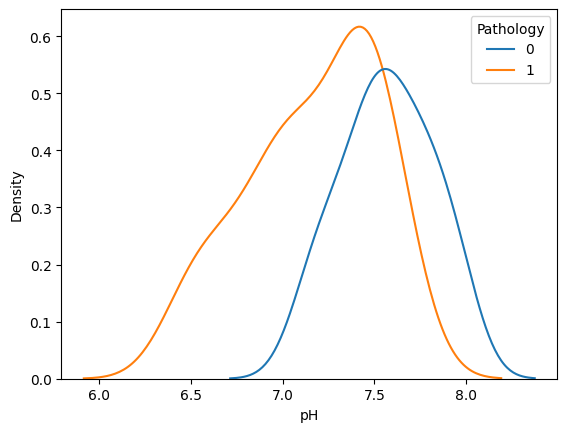

In [29]:
sns.kdeplot(data=df_120[df_120['pH'] != 0] , x='pH', hue='Pathology')
print(f"There are defined pH for {df_120[df_120['pH'] != 0].shape[0]} samples")

## Collection centers

Let's see (visually) the distribution of biomarkers, total protein and collected volume across collection centers.

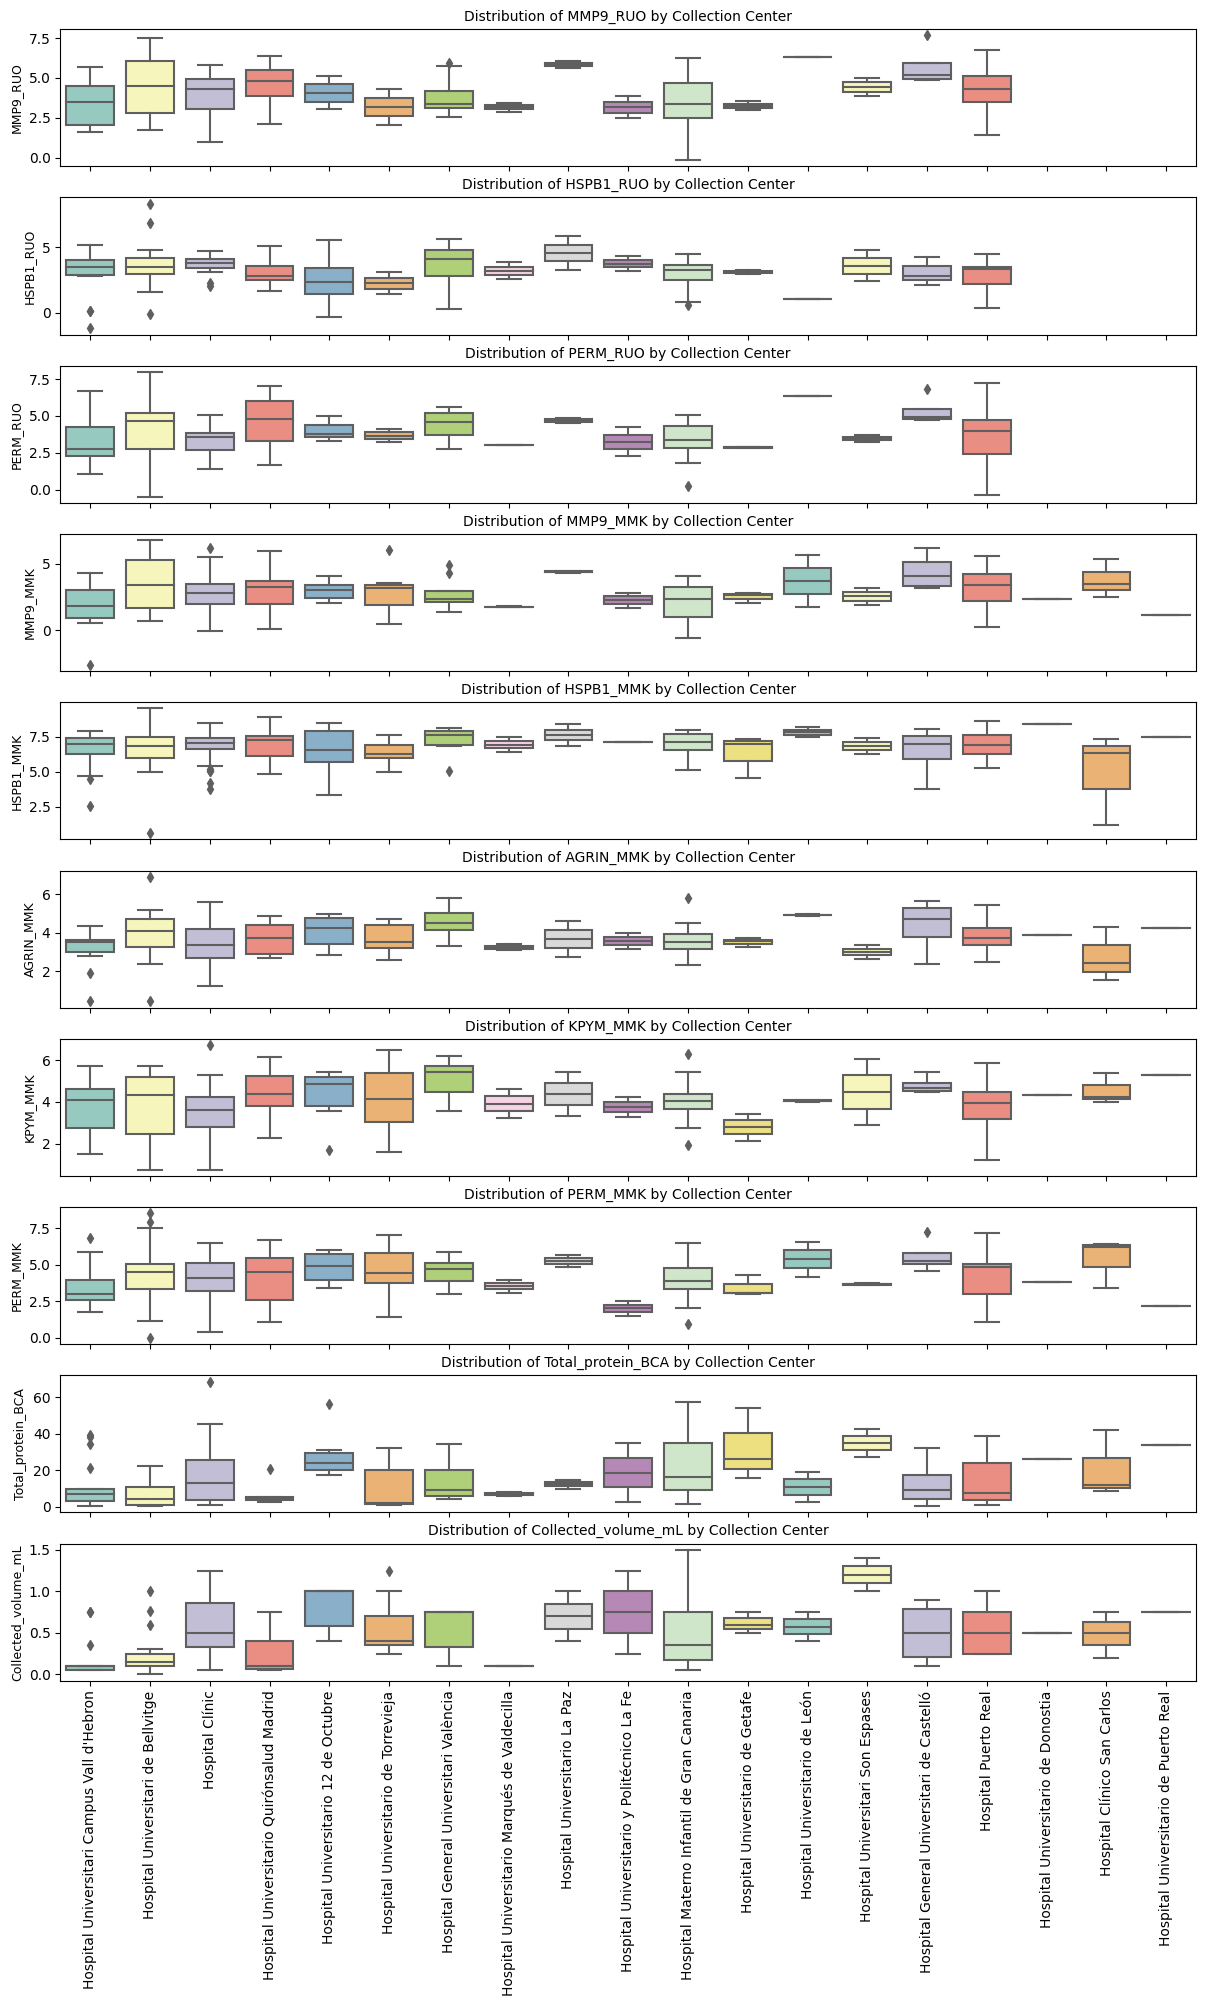

In [56]:
df = df_120.copy()
variables = ['MMP9_RUO', 'HSPB1_RUO', 'PERM_RUO', 'MMP9_MMK', 'HSPB1_MMK', 'AGRIN_MMK', 'KPYM_MMK', 'PERM_MMK', 'Total_protein_BCA', 'Collected_volume_mL']

# Normalize and apply log to biomarkers
for var in variables:
    if var != 'Total_protein_BCA' and var != 'Collected_volume_mL':
        df[var] = df[var].div(df['Total_protein_BCA'], axis=0).apply(lambda x: np.log(x) if x > 0 else np.nan)

fig, axes = plt.subplots(len(variables), 1, figsize=(12, 2 * len(variables)), sharex=True)

for i, var in enumerate(variables):
    sns.boxplot(ax=axes[i], x='Collection_center', y=var, data=df, palette='Set3')
    axes[i].set_title(f'Distribution of {var} by Collection Center', fontsize=10)
    axes[i].set_ylabel(var, fontsize=9)
    axes[i].set_xlabel('') 

plt.xticks(rotation=90)
plt.tight_layout(pad=0.5)
plt.show()

Let's perform a one-way ANOVA, suited for multiple independent groups, was used to test if the means of each variable differ significantly across the collection centers.

In [57]:
anova_results = {}
for var in variables:
    groups = [group[var].dropna() for name, group in df.groupby('Collection_center') if not group[var].dropna().empty]
    
    if len(groups) > 1:
        f_stat, p_value = f_oneway(*groups)
        anova_results[var] = p_value
    else:
        anova_results[var] = None

for var, p_value in anova_results.items():
    if p_value is not None:
        if p_value < 0.05:
            print(f"{var}: Significant difference between collection centers (p-value = {p_value:.4f})")
        else:
            print(f"{var}: No significant difference between collection centers (p-value = {p_value:.4f})")
    else:
        print(f"{var}: Not enough data to perform ANOVA")

MMP9_RUO: No significant difference between collection centers (p-value = 0.2215)
HSPB1_RUO: No significant difference between collection centers (p-value = 0.7335)
PERM_RUO: No significant difference between collection centers (p-value = 0.5870)
MMP9_MMK: No significant difference between collection centers (p-value = 0.1456)
HSPB1_MMK: No significant difference between collection centers (p-value = 0.7600)
AGRIN_MMK: No significant difference between collection centers (p-value = 0.1707)
KPYM_MMK: No significant difference between collection centers (p-value = 0.3870)
PERM_MMK: No significant difference between collection centers (p-value = 0.3758)
Total_protein_BCA: Significant difference between collection centers (p-value = 0.0084)
Collected_volume_mL: Significant difference between collection centers (p-value = 0.0000)


No significant biomarker levels were found across collection centers. There are significant differences for total protein and collected volume, this is most probably because samples coming from centers with a low $n$ are biased towards benign and cancer samples.

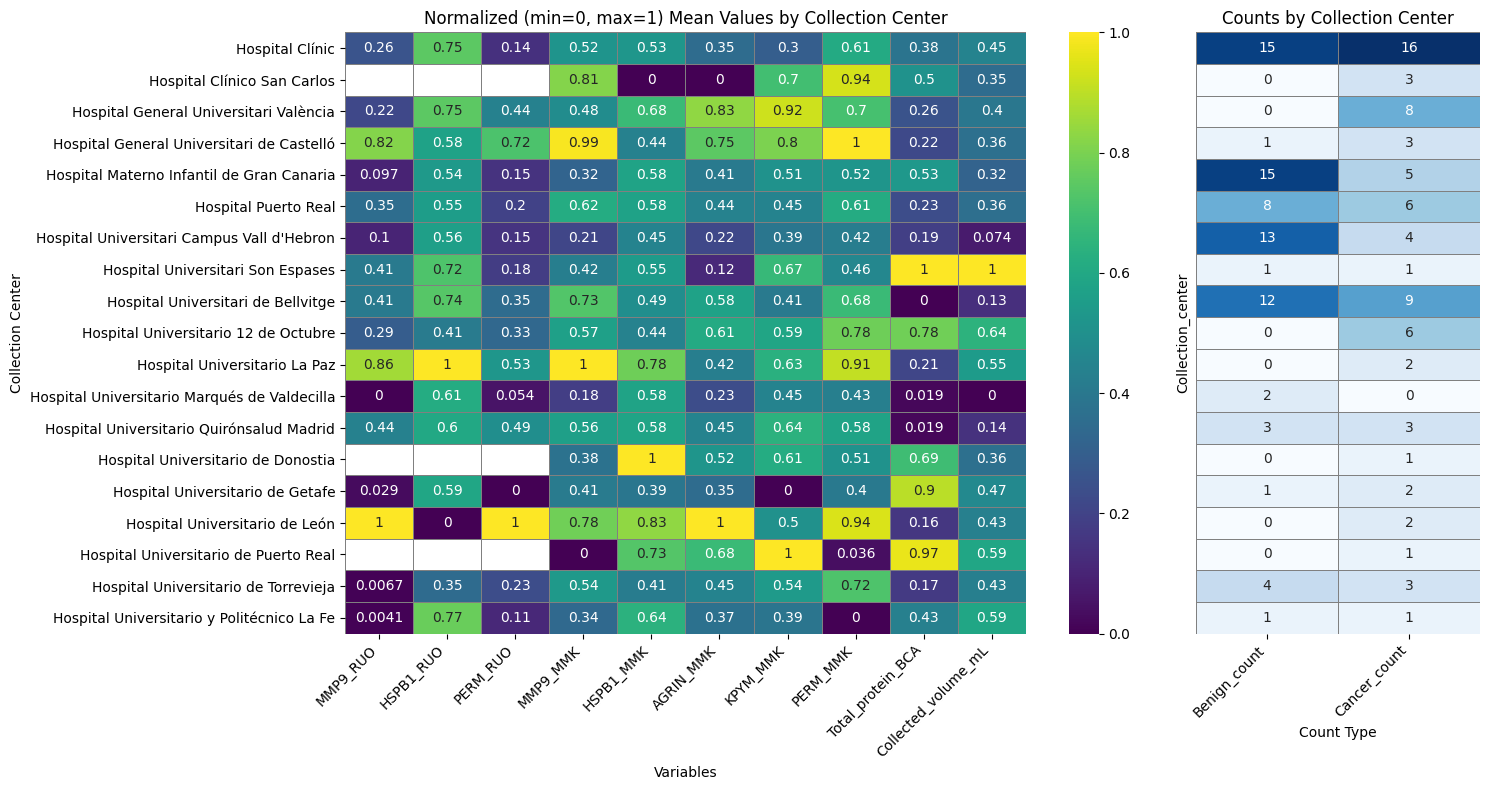

In [59]:
df = df_120.copy()
variables = ['MMP9_RUO', 'HSPB1_RUO', 'PERM_RUO', 'MMP9_MMK', 'HSPB1_MMK', 'AGRIN_MMK', 'KPYM_MMK', 'PERM_MMK', 
             'Total_protein_BCA', 'Collected_volume_mL']

# Apply normalization and  log transformation 
for var in variables:
    if var != 'Total_protein_BCA' and var != 'Collected_volume_mL':
        df[var] = df[var].div(df['Total_protein_BCA'], axis=0).apply(lambda x: np.log(x) if x > 0 else np.nan)

mean_values = df.groupby('Collection_center')[variables].mean()

# Mean values column-wise (min-max scaling)
normalized_mean_values = mean_values.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

counts = df.groupby('Collection_center')['Pathology'].value_counts().unstack().fillna(0)
counts.columns = ['Benign_count', 'Cancer_count']

fig = plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1], wspace=0.0)

ax0 = plt.subplot(gs[0])
sns.heatmap(normalized_mean_values, annot=True, cmap='viridis', linewidths=0.5, linecolor='gray', ax=ax0)
ax0.set_title('Normalized (min=0, max=1) Mean Values by Collection Center')
ax0.set_xlabel('Variables')
ax0.set_ylabel('Collection Center')
ax0.set_xticklabels(ax0.get_xticklabels(), rotation=45, ha='right')

ax1 = plt.subplot(gs[1])
sns.heatmap(counts, annot=True, cmap='Blues', linewidths=0.5, linecolor='gray', cbar=False, ax=ax1)
ax1.set_title('Counts by Collection Center')
ax1.set_xlabel('Count Type')
ax1.set_yticks([])  # Remove y-axis labels for the right plot
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


All the columns here are normalized in order to have meaningful colors, being 0 the minimum value and 1 the maximum value for each variable. Here, a row having significant low or high values could be indicating a problem, but there are not. 

**Hospital Universitario La Paz** or **Hospital Universitario de Leon** have high values or **Hospital Universitario Marqués de Valdecilla** have low values but this is because the bias of the conditions they have and are not extreme neither.